## 程序说明

#### 目录下保存了训练过程中的损失变化与准确性变化(存为npy文件)，训练后的模型也被保存。若运行该文档时，检测到目录下有这些文件，就会调用display函数展示之前的训练过程，并加载模型测试在测试集上的精确度。删去这些文件可以重新训练模型。

#### 如果没有删除文件，直接点击运行相当于展示之前的训练过程，并加载模型测试在测试集上的精确度，但训练过程中的部分prrint和图像就没了，建议在运行前先阅读程序并看之前展示的图像和数据，阅读完毕后再点击运行，检查模型的效果。

In [11]:
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import random
import os

In [2]:
#  creating neural network
class IrisNet(nn.Module):
    def __init__(self, activation):
        super(IrisNet,self).__init__()
        if activation is 'ReLU':
            self.input = nn.Sequential(
                nn.Linear(4, 40),
                nn.ReLU(inplace=True)
            )  
        elif activation is 'Sigmoid':
            self.input = nn.Sequential(
                nn.Linear(4, 40),
                nn.Sigmoid()
            )  
        elif activation is 'Softmax':
            self.input = nn.Sequential(
                nn.Linear(4, 40),
                nn.Softmax(dim=0)
            )  
        
        self.out = nn.Linear(40,3)

    def forward(self, x):
        x = self.input(x)
        return self.out(x)

In [3]:
def set_seed(seed=0):
    np.random.seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


In [4]:
set_seed(10)

# data reading and data pre-processing
Iris_dataset = pd.read_table('iris.data', delimiter=',',header=None) # read data as dataframe
Iris_dataset = Iris_dataset.sample(frac = 1).reset_index(drop=True) # shuffle 

# convert ['Iris-setosa' 'Iris-versicolor' 'Iris-virginica'] into [0 1 2]
category_dic = {}
for i,category in enumerate(Iris_dataset[4].unique()):
    Iris_dataset.loc[Iris_dataset[4]==category,4]=i
    category_dic[i] = category
    
# normalization: min-max
'''
for index, data in Iris_dataset.iteritems():
    max_data = max(data)
    min_data = min(data)
    Iris_dataset.loc[:, index] = (data-min_data)/(max_data-min_data)
    if index is 3:
        break
'''
print(Iris_dataset)

       0    1    2    3  4
0    6.3  2.3  4.4  1.3  0
1    6.4  2.7  5.3  1.9  1
2    5.4  3.7  1.5  0.2  2
3    6.1  3.0  4.6  1.4  0
4    5.0  3.3  1.4  0.2  2
5    5.0  2.0  3.5  1.0  0
6    6.3  2.5  4.9  1.5  0
7    5.8  2.7  4.1  1.0  0
8    5.1  3.4  1.5  0.2  2
9    5.7  2.8  4.5  1.3  0
10   5.6  3.0  4.5  1.5  0
11   5.8  2.7  5.1  1.9  1
12   5.5  2.3  4.0  1.3  0
13   4.9  3.0  1.4  0.2  2
14   5.1  3.8  1.5  0.3  2
15   6.8  3.0  5.5  2.1  1
16   6.0  3.4  4.5  1.6  0
17   4.4  3.0  1.3  0.2  2
18   5.1  3.7  1.5  0.4  2
19   5.0  3.2  1.2  0.2  2
20   7.1  3.0  5.9  2.1  1
21   6.4  2.8  5.6  2.2  1
22   6.2  2.8  4.8  1.8  1
23   4.8  3.4  1.9  0.2  2
24   5.9  3.0  4.2  1.5  0
25   4.7  3.2  1.3  0.2  2
26   5.7  3.0  4.2  1.2  0
27   5.5  2.6  4.4  1.2  0
28   6.8  2.8  4.8  1.4  0
29   7.7  3.8  6.7  2.2  1
..   ...  ...  ...  ... ..
120  6.7  3.1  4.7  1.5  0
121  5.8  2.6  4.0  1.2  0
122  6.2  3.4  5.4  2.3  1
123  5.0  3.0  1.6  0.2  2
124  6.0  3.0  4.8  1.8  1
1

/home/zhang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: read_table is deprecated, use read_csv instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [5]:
# define the train function
def train(model, train_set, optimizer):
    model.train() 
    loss = 0
    accurate_classification = 0
    for _, data in train_set.iterrows(): # read the data row by row
        val_data = torch.from_numpy(data.values[:-1]) #  turn into tensor
        classification = model(val_data.float()) # a tensor which represents the probability of each category 
        
        target = torch.zeros_like(classification)
        target[int(data.values[-1])] = 1 # if it is class 2: [0,0,1]
        loss += (target - classification).pow(2).sum() 
        if int(torch.max(classification.unsqueeze(0), 1)[1].item()) == int(data.values[-1]):
            # record the correct classification
            accurate_classification += 1
            
    # compute gradient and do Adam step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()/train_set.shape[0], accurate_classification/train_set.shape[0]

def validation(model, val_set):
    model.eval()
    loss = 0
    accurate_classification = 0
    for _, data in val_set.iterrows(): # read the data row by row
        val_data = torch.from_numpy(data.values[:-1]) #  turn into tensor
        
        classification = model(val_data.float()) # a tensor which represents the probability of each category 
        target = torch.zeros_like(classification)
        target[int(data.values[-1])] = 1 # if it is class 2: [0,0,1]
        
        loss += (target - classification).pow(2).sum()
        if int(torch.max(classification.unsqueeze(0), 1)[1].item()) == int(data.values[-1]):
            # record the correct classification
            accurate_classification += 1
            
    return loss.item()/val_set.shape[0], accurate_classification/val_set.shape[0]

In [6]:
# the main function 
def Train_and_Test(choose_activation):
    model = IrisNet(activation=choose_activation) # model creating with your choice of activation function 
    parameters = model.parameters()
    
    # choose Adatm optimizer
    optimizer = torch.optim.Adam(parameters, lr = 0.005,
                                     betas=(0.9, 0.999),
                                     weight_decay=0)
    
    # divide the training set and validation set
    train_dataset = Iris_dataset.loc[:int(0.8*Iris_dataset.shape[0])]
    val_dataset = Iris_dataset.loc[int(0.8*Iris_dataset.shape[0]):]

    train_loss_epoch = []
    test_loss_epoch = []
    train_accuracy_epoch = []
    test_accuracy_epoch = []
    for epoch in range(0,200):
        train_loss, train_accuracy = train(model,train_dataset,optimizer)
        test_loss, test_accuracy = validation(model, val_dataset)

        train_loss_epoch.append(train_loss)
        test_loss_epoch.append(test_loss)
        train_accuracy_epoch.append(train_accuracy)
        test_accuracy_epoch.append(test_accuracy)
    # save the model 
    torch.save(model.state_dict(), '{}_model.pth.tar'.format(choose_activation))
    
    # save the data during the training process
    np.save('{}train_loss_epoch.npy'.format(choose_activation), np.array(train_loss_epoch))
    np.save('{}test_loss_epoch.npy'.format(choose_activation), np.array(test_loss_epoch))
    np.save('{}train_accuracy_epoch.npy'.format(choose_activation), np.array(train_accuracy_epoch))
    np.save('{}test_accuracy_epoch.npy'.format(choose_activation), np.array(test_accuracy_epoch))
    return train_loss_epoch,test_loss_epoch,train_accuracy_epoch,test_accuracy_epoch


In [7]:
def visualization(train_loss_epoch,test_loss_epoch,train_accuracy_epoch,test_accuracy_epoch,choose_activation):
    print('{}:Accuracy on train set'.format(choose_activation),train_accuracy_epoch[-1])
    print('{}:Accuracy on validation set'.format(choose_activation),test_accuracy_epoch[-1])
    index = list(range(len(train_loss_epoch)))

    plt.subplot(2,  1,  1) 
    l1,=plt.plot(index,test_accuracy_epoch)
    l2,=plt.plot(index,train_accuracy_epoch)
    plt.legend(handles = [l1, l2,], labels = ['validation', 'train'], loc = 'best')
    plt.ylabel('Accuracy') 
    plt.xlabel('epoch')
    plt.title('{}:Accuracy on Train Set and Validation Set'.format(choose_activation)) 

    plt.subplot(2,  1,  2) 
    l1,=plt.plot(index,test_loss_epoch)
    l2,=plt.plot(index,train_loss_epoch)
    plt.legend(handles = [l1, l2,], labels = ['validation', 'train'], loc = 'best')
    plt.ylabel('Loss') 
    plt.xlabel('epoch')
    plt.title('{}:Loss on Train Set and Validation Set'.format(choose_activation)) 

    plt.show()

In [8]:
def display():
    #reading the npy file saved previously
    ReLUtest_accuracy_epoch = np.load('ReLUtest_accuracy_epoch.npy').tolist()
    ReLUtest_loss_epoch = np.load('ReLUtest_loss_epoch.npy').tolist()
    ReLUtrain_accuracy_epoch = np.load('ReLUtrain_accuracy_epoch.npy').tolist()
    ReLUtrain_loss_epoch = np.load('ReLUtrain_loss_epoch.npy').tolist()
    Sigmoidtest_accuracy_epoch = np.load('Sigmoidtest_accuracy_epoch.npy').tolist()
    Sigmoidtest_loss_epoch = np.load('Sigmoidtest_loss_epoch.npy').tolist()
    Sigmoidtrain_accuracy_epoch = np.load('Sigmoidtrain_accuracy_epoch.npy').tolist()
    Sigmoidtrain_loss_epoch = np.load('Sigmoidtrain_loss_epoch.npy').tolist()
    Softmaxtest_accuracy_epoch = np.load('Softmaxtest_accuracy_epoch.npy').tolist()
    Softmaxtest_loss_epoch = np.load('Softmaxtest_loss_epoch.npy').tolist()
    Softmaxtrain_accuracy_epoch = np.load('Softmaxtrain_accuracy_epoch.npy').tolist()
    Softmaxtrain_loss_epoch = np.load('Softmaxtrain_loss_epoch.npy').tolist()
    
    index = list(range(len(ReLUtest_accuracy_epoch)))
    l1,=plt.plot(index,ReLUtrain_loss_epoch)
    l2,=plt.plot(index,Sigmoidtrain_loss_epoch)
    l3,=plt.plot(index,Softmaxtrain_loss_epoch)
    plt.legend(handles = [l1, l2, l3], labels = ['ReLU', 'Sigmoid', 'Softmax'], loc = 'best')
    plt.ylabel('Loss') 
    plt.xlabel('epoch')
    plt.title('Loss on Train Set') 
    plt.show()
    
    index = list(range(len(ReLUtest_accuracy_epoch)))
    l1,=plt.plot(index,ReLUtest_loss_epoch)
    l2,=plt.plot(index,Sigmoidtest_loss_epoch)
    l3,=plt.plot(index,Softmaxtest_loss_epoch)
    plt.legend(handles = [l1, l2, l3], labels = ['ReLU', 'Sigmoid', 'Softmax'], loc = 'best')
    plt.ylabel('Loss') 
    plt.xlabel('epoch')
    plt.title('Loss on validation Set') 
    plt.show()
    
    index = list(range(len(ReLUtest_accuracy_epoch)))
    l1,=plt.plot(index,ReLUtrain_accuracy_epoch)
    l2,=plt.plot(index,Sigmoidtrain_accuracy_epoch)
    l3,=plt.plot(index,Softmaxtrain_accuracy_epoch)
    plt.legend(handles = [l1, l2, l3], labels = ['ReLU', 'Sigmoid', 'Softmax'], loc = 'best')
    plt.ylabel('Accuracy') 
    plt.xlabel('epoch')
    plt.title('Accuracy on train Set') 
    plt.show()
    
    index = list(range(len(ReLUtest_accuracy_epoch)))
    l1,=plt.plot(index,ReLUtest_accuracy_epoch)
    l2,=plt.plot(index,Sigmoidtest_accuracy_epoch)
    l3,=plt.plot(index,Softmaxtest_accuracy_epoch)
    plt.legend(handles = [l1, l2, l3], labels = ['ReLU', 'Sigmoid', 'Softmax'], loc = 'best')
    plt.ylabel('Accuracy') 
    plt.xlabel('epoch')
    plt.title('Accuracy on validation Set') 
    plt.show()
    
    

ReLU:Accuracy on train set 0.9586776859504132
ReLU:Accuracy on validation set 1.0


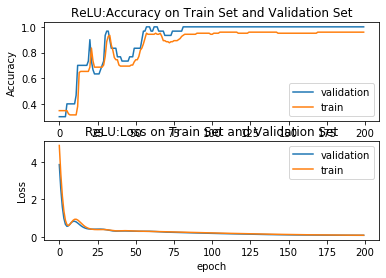

Sigmoid:Accuracy on train set 0.9669421487603306
Sigmoid:Accuracy on validation set 1.0


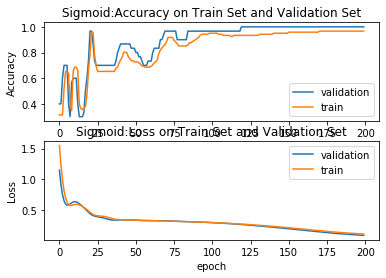

Softmax:Accuracy on train set 0.9669421487603306
Softmax:Accuracy on validation set 1.0


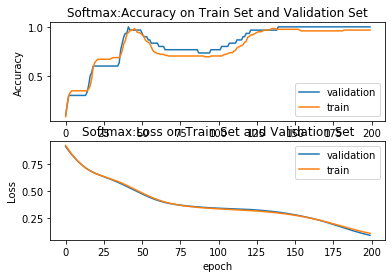

In [9]:
if not os.path.exists('ReLU_model.pth.tar'):
    
    # model with ReLU
    train_loss_epoch_ReLU,test_loss_epoch_ReLU,train_accuracy_epoch_ReLU,test_accuracy_epoch_ReLU = Train_and_Test('ReLU')
    visualization(train_loss_epoch_ReLU,test_loss_epoch_ReLU,train_accuracy_epoch_ReLU,test_accuracy_epoch_ReLU,'ReLU')
    
    # model with Sigmoid
    train_loss_epoch_Sigmoid,test_loss_epoch_Sigmoid,train_accuracy_epoch_Sigmoid,test_accuracy_epoch_Sigmoid = Train_and_Test('Sigmoid')
    visualization(train_loss_epoch_Sigmoid,test_loss_epoch_Sigmoid,train_accuracy_epoch_Sigmoid,test_accuracy_epoch_Sigmoid,'Sigmoid')
    
    # model with Softmax
    train_loss_epoch_Softmax,test_loss_epoch_Softmax,train_accuracy_epoch_Softmax,test_accuracy_epoch_Softmax = Train_and_Test('Softmax')
    visualization(train_loss_epoch_Softmax,test_loss_epoch_Softmax,train_accuracy_epoch_Softmax,test_accuracy_epoch_Softmax,'Softmax')


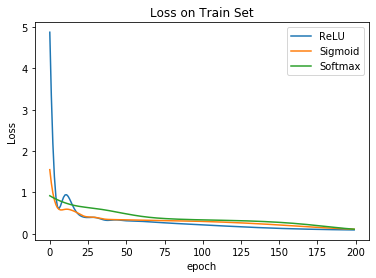

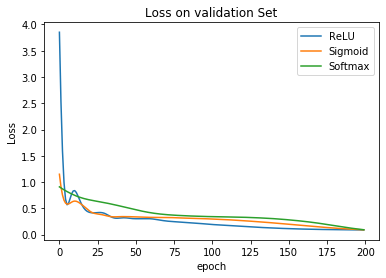

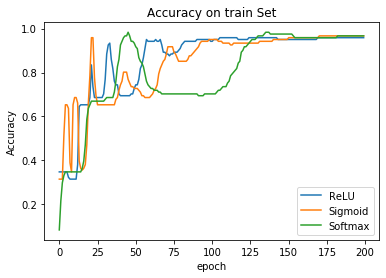

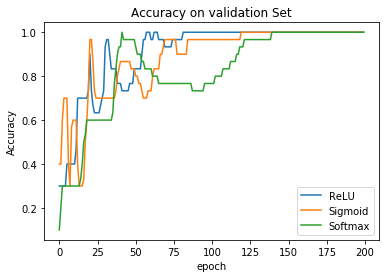

ReLU:test_accuracy: 1.0
Softmax:test_accuracy: 1.0
Sigmoid:test_accuracy: 1.0


In [10]:
if  os.path.exists('ReLU_model.pth.tar'):
    # display the training process
    display()
    
    # validation on the validation set
    val_dataset = Iris_dataset.loc[int(0.8*Iris_dataset.shape[0]):]
    # load the model 
    ReLU_model = IrisNet('ReLU')
    weights = torch.load('ReLU_model.pth.tar')
    ReLU_model.load_state_dict(weights)
    
    Softmax_model= IrisNet('Softmax')
    weights = torch.load('Softmax_model.pth.tar')
    Softmax_model.load_state_dict(weights)   
    
    Sigmoid_model = IrisNet('Sigmoid')
    weights = torch.load('Sigmoid_model.pth.tar')
    Sigmoid_model.load_state_dict(weights)
    
    # validation
    ReLU_model.eval()
    Softmax_model.eval()
    Sigmoid_model.eval()
    
    _, ReLUtest_accuracy = validation(ReLU_model, val_dataset)
    _, Softmaxtest_accuracy = validation(Softmax_model, val_dataset)
    _, Sigmoidtest_accuracy = validation(Sigmoid_model, val_dataset)
    print('ReLU:test_accuracy:',ReLUtest_accuracy)
    print('Softmax:test_accuracy:',Softmaxtest_accuracy)
    print('Sigmoid:test_accuracy:',Sigmoidtest_accuracy)